In [872]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import clone
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import graphviz


In [873]:
## Load Dataset
data = pd.read_sas('a2z_insurance.sas7bdat')
data

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,10292.0,1984.0,1949.0,b'4 - PhD',3188.0,2.0,0.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78
10292,10293.0,1977.0,1952.0,b'1 - Basic',2431.0,3.0,0.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13
10293,10294.0,1994.0,1976.0,b'3 - BSc/MSc',2918.0,1.0,1.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89
10294,10295.0,1981.0,1977.0,b'1 - Basic',1971.0,2.0,1.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91


In [874]:
### Copied from Joice
def educDegtransform(row):
    row = row.decode("utf-8") if type(row) == bytes else row 
    if type(row) == str:
        educ_dict = {
            '1 - Basic': 1,
            '2 - High School': 2,
            '3 - BSc/MSc': 3,
            '4 - PhD': 4
        }
        return educ_dict[row]
    else:
        return row

data['EducDeg'] = data['EducDeg'].apply(lambda row: educDegtransform(row)) 



df = data
df['CustID'] = df['CustID'].astype('int')
df = df.set_index('CustID')


In [875]:
##Number of null values on each column:
df.isnull().sum()

FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

## Inputing missing numerical values

In [876]:
# Define metric and non-metric features
non_metric_features = ['EducDeg', 'GeoLivArea', 'Children']
metric_features = df.columns.drop(non_metric_features).to_list()
metric_features = [x for x in metric_features if x not in 'CustID']

print('non metric features: ', non_metric_features)
print('metric features: ', metric_features)

non metric features:  ['EducDeg', 'GeoLivArea', 'Children']
metric features:  ['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']


In [877]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22,1977.0,1958.0,2.0,NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
69,1983.0,1977.0,2.0,1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139,1979.0,1976.0,2.0,2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
144,1996.0,1990.0,3.0,NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
185,1993.0,1984.0,2.0,2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011,NaN,1947.0,2.0,3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10058,1983.0,1980.0,2.0,1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10143,1986.0,1985.0,3.0,1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78


In [878]:
# KNNImputer - only works for numerical varaibles
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

In [879]:
# See rows with NaNs imputed
df_neighbors.loc[nans_index, metric_features]

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,
22,1977.0,1958.0,2541.2,111.37,0.80,407.520,111.70,100.130,24.670,30.340
69,1983.0,1977.0,1399.0,476.65,0.33,330.730,186.70,211.150,33.784,15.780
139,1979.0,1976.0,2538.0,149.59,0.69,194.260,305.60,226.598,37.340,17.670
144,1996.0,1990.0,1721.8,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
185,1993.0,1984.0,2419.0,-62.23,1.07,264.428,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...
10011,1990.8,1947.0,3959.0,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10058,1983.0,1980.0,1569.0,222.60,0.55,235.600,211.15,247.602,32.340,68.790
10143,1986.0,1985.0,1652.0,55.67,0.88,257.050,94.45,308.390,23.338,13.780


In [880]:
df = df_neighbors.copy()
##Number of null values on each column:
df.isnull().sum()

FirstPolYear      0
BirthYear         0
EducDeg          17
MonthSal          0
GeoLivArea        1
Children         21
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
dtype: int64

In [881]:
modes = df[non_metric_features].mode().loc[0]
modes

EducDeg       3.0
GeoLivArea    4.0
Children      1.0
Name: 0, dtype: float64

In [882]:
#df.fillna(df.median(), inplace=True)
df.fillna(modes, inplace=True)
df.isna().sum()  # checking how many NaNs we still have

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

### Check Duplicated data

In [883]:
## Duplicated rows
df[df.duplicated(keep=False)]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
2076,1977.0,1974.0,2.0,2204.0,4.0,1.0,-22.11,1.00,214.93,88.90,266.94,39.23,42.12
2100,1987.0,1987.0,2.0,1912.0,4.0,1.0,290.61,0.58,202.37,177.25,306.39,63.90,-0.11
3507,1986.0,1952.0,2.0,3900.0,4.0,0.0,-119.35,1.10,163.03,481.75,224.82,94.35,18.56
8014,1987.0,1987.0,2.0,1912.0,4.0,1.0,290.61,0.58,202.37,177.25,306.39,63.90,-0.11
8122,1977.0,1974.0,2.0,2204.0,4.0,1.0,-22.11,1.00,214.93,88.90,266.94,39.23,42.12
9554,1986.0,1952.0,2.0,3900.0,4.0,0.0,-119.35,1.10,163.03,481.75,224.82,94.35,18.56


In [884]:
df.drop_duplicates(keep='first', inplace=True)

## Data Normalization

In [885]:
df_scaled = df.copy()

In [886]:
# Use MinMaxScaler to scale the data
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
scaled_feat

array([[-1.18499377e-02,  7.10297604e-01, -2.84925769e-01, ...,
        -8.53067021e-02,  1.13905601e-01, -4.72285503e-01],
       [-1.96842864e-02,  1.37014906e+00, -1.58236116e+00, ...,
        -1.85600564e-01,  3.22830372e+00,  1.26461980e+00],
       [-9.84145816e-05,  1.01203951e-01, -1.98430077e-01, ...,
        -1.58929901e-01,  9.44721509e-01,  1.12623570e+00],
       ...,
       [ 5.77734695e-03,  4.05750777e-01,  3.56007313e-01, ...,
        -9.91997851e-02, -6.11316014e-01, -7.05845158e-01],
       [-1.96842864e-02,  4.56508582e-01, -4.63106896e-01, ...,
         9.05033326e-02,  4.70603127e-01,  1.39658101e+00],
       [-2.05700176e-03,  6.59539799e-01,  2.66916749e-01, ...,
        -1.02580097e-01, -7.33383018e-01, -5.50138721e-01]])

In [887]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.mean_, "\n", scaler.var_)

Parameters fitted:
 [1.99105025e+03 1.96800614e+03 2.50641036e+03 1.77929963e+02
 7.42728068e-01 3.00702459e+02 2.10419863e+02 1.71596339e+02
 4.16164510e+01 4.11554324e+01] 
 [2.60683886e+05 3.88145312e+02 1.33662949e+06 3.78690439e+06
 8.51030875e+00 4.48032141e+04 1.24339391e+05 8.75157841e+04
 2.24212129e+03 2.63977457e+03]


In [888]:
df_scaled[metric_features] = scaled_feat
df_scaled.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1,-0.011850,0.710298,2.0,-0.284926,1.0,1.0,0.104337,-0.120911,0.355026,-0.371421,-0.085307,0.113906,-0.472286
2,-0.019684,1.370149,2.0,-1.582361,4.0,1.0,-0.158818,0.129325,-1.054684,0.583578,-0.185601,3.228304,1.264620
3,-0.000098,0.101204,1.0,-0.198430,3.0,0.0,0.167904,-0.158618,-0.446702,0.039930,-0.158930,0.944722,1.126236
4,-0.002057,0.659540,3.0,-1.217349,4.0,1.0,-0.100165,0.084762,-0.558529,-0.473799,0.471803,-0.132551,-0.249431
5,-0.009891,0.253477,3.0,-0.643018,4.0,1.0,-0.073330,0.053911,0.179137,-0.461179,0.037162,-0.482280,0.005733


In [889]:
df = df_scaled.copy()

## One-hot encoding

In [890]:
df_ohc = df.copy()

In [891]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head()

,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0
CustID,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [892]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0
CustID,,,,,,,,,,,,,,,,,
1,-0.011850,0.710298,-0.284926,0.104337,-0.120911,0.355026,-0.371421,-0.085307,0.113906,-0.472286,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.019684,1.370149,-1.582361,-0.158818,0.129325,-1.054684,0.583578,-0.185601,3.228304,1.264620,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.000098,0.101204,-0.198430,0.167904,-0.158618,-0.446702,0.039930,-0.158930,0.944722,1.126236,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.002057,0.659540,-1.217349,-0.100165,0.084762,-0.558529,-0.473799,0.471803,-0.132551,-0.249431,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,-0.009891,0.253477,-0.643018,-0.073330,0.053911,0.179137,-0.461179,0.037162,-0.482280,0.005733,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [893]:
df = df_ohc.copy()
#df

## Outlier removal

In [894]:
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])
Counter(dbscan_labels)

Counter({0: 10262, -1: 31})

In [895]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()
df_original = df.copy()
df = df[dbscan_labels!=-1].copy()

In [896]:
print('Outliers size: ',df_out.shape)
print('DF without outliers: ',df.shape)
print('Without removing outliers: ',df_original.shape)


Outliers size:  (31, 17)
DF without outliers:  (10262, 17)
Without removing outliers:  (10293, 17)


# Clustering by Perspectives
- Demographic/Behavioral Perspective: (Age and time of assingment)
- Claimns and Premiums

In [897]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
demographic_features = [
    'MonthSal',
    'BirthYear',
    'FirstPolYear'   
]

preference_features = [
    'CustMonVal', ### We will decide if we move this variable to another group
    'ClaimsRate',
    'PremMotor',
    'PremHousehold',
    'PremHealth',
    'PremLife',
    'PremWork' 
]

df_dem = df[demographic_features].copy()
df_prf = df[preference_features].copy()

## Testing on K-means and Hierarchical clustering

In [898]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

### Finding the optimal clusterer on demographic variables

In [899]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_dem, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.715010,0.706108,0.695645,0.000122,0.712817
3,0.847203,0.806449,0.695749,0.000176,0.815522
4,0.896087,0.884358,0.826497,0.000273,0.888121
5,0.919871,0.896738,0.879632,0.001218,0.909059
6,0.932795,0.906332,0.879679,0.001339,0.926039
7,0.940482,0.915339,0.879725,0.001393,0.933775
8,0.946205,0.922431,0.879882,0.002100,0.938818
9,0.950571,0.935693,0.906365,0.002182,0.943328


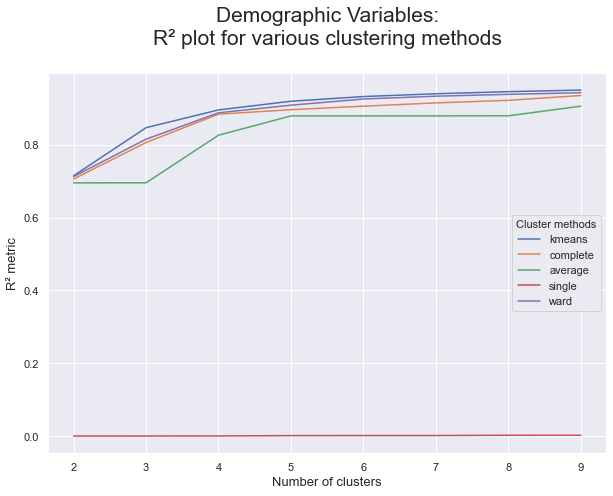

In [900]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Repeat the process for premium variables

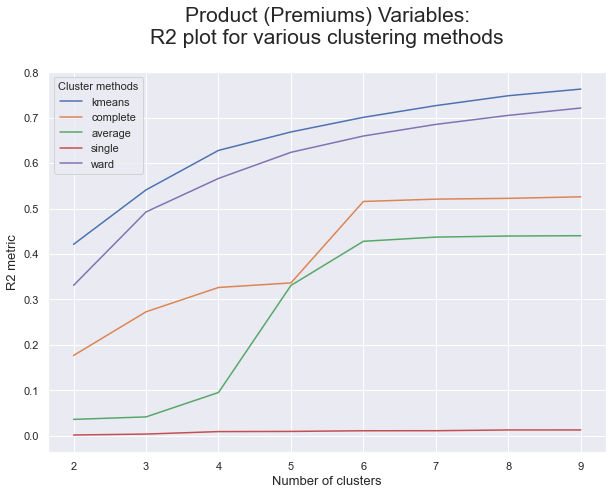

In [901]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_prf, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_prf, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product (Premiums) Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

In [902]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
prod_labels = kmeans_prod.fit_predict(df_prf)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behav.fit_predict(df_dem)

df['product_labels'] = prod_labels
df['behavior_labels'] = behavior_labels

In [903]:
# Count label frequencies (contigency table)
df.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,998,407,1030
1,201,932,1328
2,115,1735,764
3,123,1785,844


In [904]:
### Manual merging: Merge lowest frequency clusters into closest clusters
# Clusters with low frequency to be merged:
to_merge = [(3,2), (1,0), (2,2), (0,2)]

df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(3, 2): (1, 2), (1, 0): (3, 0), (2, 2): (0, 2)}

In [905]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['product_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'product_labels'] = target[1]

# New contigency table
df_.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,998.0,407.0,1794.0
1,NaN,932.0,2172.0
2,115.0,1735.0,NaN
3,324.0,1785.0,NaN


### Merging using Hierarchical clustering

In [906]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()
df_centroids

FirstPolYear  BirthYear  MonthSal  CustMonVal  \
behavior_labels product_labels                                                  
0               0                  -0.009792   1.337507 -1.217970    0.057277   
                1                  -0.009620   0.942262 -0.987095    0.006499   
                2                  -0.010610   1.053677 -1.037649    0.030793   
1               0                  -0.008098  -1.108903  1.065517    0.026248   
                1                  -0.009464  -1.123737  1.086957    0.000937   
                2                  -0.009331  -1.136889  1.094930    0.010832   
2               0                  -0.009125   0.556700 -0.393482    0.052609   
                1                  -0.010175   0.355531 -0.356986    0.011292   
                2                  -0.009176   0.539993 -0.426668    0.011835   
3               0                  -0.010003  -0.510366  0.359729    0.045244   
                1                  -0.010087  -0.325577  0.305553    0.018352   
                2                  -0.010419  -0.505159  0.393686    0.029746   

                                ClaimsRate  PremMotor  PremHousehold  \
behavior_labels product_labels                                         
0               0                -0.009467  -1.046215       0.955832   
                1                -0.023861   0.299324      -0.341643   
                2                -0.016224  -0.485786       0.262614   
1               0                -0.005352  -0.826123       0.466447   
                1                -0.018821   0.330808      -0.350914   
                2                -0.006077  -0.411463       0.122697   
2               0                -0.022069  -0.706140       0.527888   
                1                -0.032286   0.561865      -0.418024   
                2                -0.008630  -0.270336       0.068527   
3               0                -0.023230  -0.643820       0.456534   
                1                -0.039268   0.678575      -0.397167   
                2                -0.019358  -0.186597       0.163455   

                                PremHealth  PremLife  PremWork  
behavior_labels product_labels                                  
0               0                -0.051517  1.821244  1.497434  
                1                 0.014253 -0.574879 -0.496885  
                2                 0.206679  0.091542  0.207313  
1               0                 0.024426  1.677125  0.935238  
                1                -0.010713 -0.542875 -0.492823  
                2                 0.202718  0.079263  0.129904  
2               0                -0.058579  1.573195  0.882393  
                1                -0.137363 -0.615711 -0.558642  
                2                 0.118431  0.074603  0.129983  
3               0                -0.105745  1.411930  1.195250  
                1                -0.227516 -0.616829 -0.548292  
                2                 0.020023  0.168218  0.137756

In [907]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

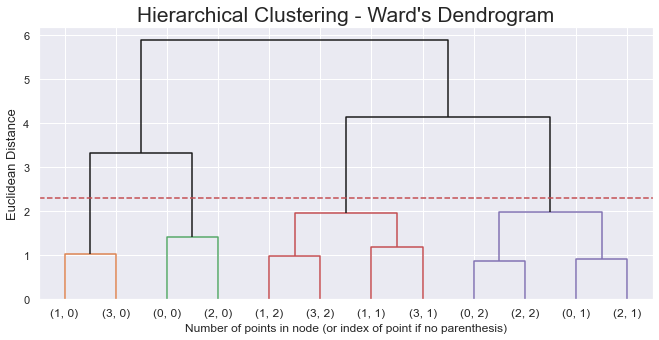

In [908]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.3
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [909]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

FirstPolYear  BirthYear  MonthSal  CustMonVal  \
behavior_labels product_labels                                                  
0               0                  -0.009792   1.337507 -1.217970    0.057277   
                1                  -0.009620   0.942262 -0.987095    0.006499   
                2                  -0.010610   1.053677 -1.037649    0.030793   
1               0                  -0.008098  -1.108903  1.065517    0.026248   
                1                  -0.009464  -1.123737  1.086957    0.000937   
                2                  -0.009331  -1.136889  1.094930    0.010832   
2               0                  -0.009125   0.556700 -0.393482    0.052609   
                1                  -0.010175   0.355531 -0.356986    0.011292   
                2                  -0.009176   0.539993 -0.426668    0.011835   
3               0                  -0.010003  -0.510366  0.359729    0.045244   
                1                  -0.010087  -0.325577  0.305553    0.018352   
                2                  -0.010419  -0.505159  0.393686    0.029746   

                                ClaimsRate  PremMotor  PremHousehold  \
behavior_labels product_labels                                         
0               0                -0.009467  -1.046215       0.955832   
                1                -0.023861   0.299324      -0.341643   
                2                -0.016224  -0.485786       0.262614   
1               0                -0.005352  -0.826123       0.466447   
                1                -0.018821   0.330808      -0.350914   
                2                -0.006077  -0.411463       0.122697   
2               0                -0.022069  -0.706140       0.527888   
                1                -0.032286   0.561865      -0.418024   
                2                -0.008630  -0.270336       0.068527   
3               0                -0.023230  -0.643820       0.456534   
                1                -0.039268   0.678575      -0.397167   
                2                -0.019358  -0.186597       0.163455   

                                PremHealth  PremLife  PremWork  hclust_labels  
behavior_labels product_labels                                                 
0               0                -0.051517  1.821244  1.497434              6  
                1                 0.014253 -0.574879 -0.496885              5  
                2                 0.206679  0.091542  0.207313              4  
1               0                 0.024426  1.677125  0.935238              1  
                1                -0.010713 -0.542875 -0.492823              0  
                2                 0.202718  0.079263  0.129904              2  
2               0                -0.058579  1.573195  0.882393              3  
                1                -0.137363 -0.615711 -0.558642              5  
                2                 0.118431  0.074603  0.129983              4  
3               0                -0.105745  1.411930  1.195250              1  
                1                -0.227516 -0.616829 -0.548292              0  
                2                 0.020023  0.168218  0.137756              2

In [910]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['product_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
merged_labels,,,,,,,,,,
0,-0.009873,-0.599366,0.573595,0.012378,-0.032254,0.559282,-0.381301,-0.153147,-0.591461,-0.529265
1,-0.008821,-0.881680,0.797579,0.033460,-0.012139,-0.756915,0.462684,-0.024990,1.576449,1.033946
2,-0.009754,-0.891410,0.822439,0.018181,-0.011238,-0.324084,0.138535,0.131726,0.113829,0.132955
3,-0.009125,0.556700,-0.393482,0.052609,-0.022069,-0.706140,0.527888,-0.058579,1.573195,0.882393
4,-0.009999,0.834917,-0.777454,0.022719,-0.012990,-0.394033,0.179959,0.169097,0.084329,0.174381
5,-0.010069,0.467016,-0.476712,0.010381,-0.030685,0.511980,-0.403511,-0.108555,-0.607952,-0.546908
6,-0.009792,1.337507,-1.217970,0.057277,-0.009467,-1.046215,0.955832,-0.051517,1.821244,1.497434


In [911]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['product_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,998.0,NaN,NaN
2,115.0,2142.0,1794.0
3,324.0,2717.0,2172.0


In [912]:
df = df_.copy()

## Cluster Analysis

In [913]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

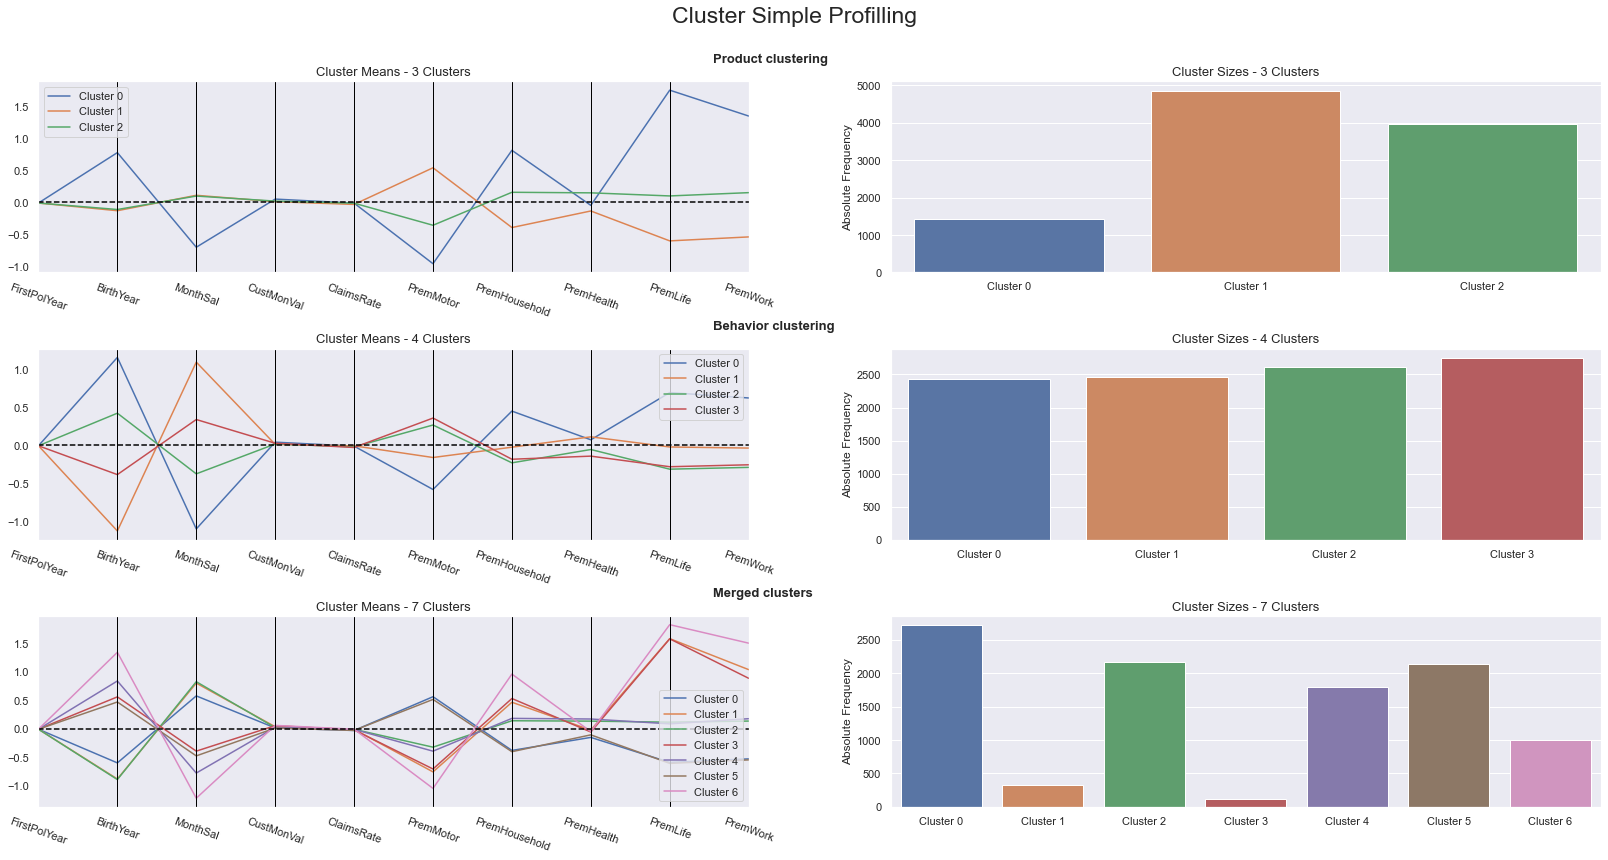

In [914]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['product_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['product_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Product clustering", "Behavior clustering", "Merged clusters"]
)

## Cluster visualization using t-SNE

In [915]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

c:\Users\Crs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Crs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [916]:
df

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0,product_labels,behavior_labels,merged_labels
CustID,,,,,,,,,,,,,,,,,,,,
1,-0.011850,0.710298,-0.284926,0.104337,-0.120911,0.355026,-0.371421,-0.085307,0.113906,-0.472286,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2,5
2,-0.019684,1.370149,-1.582361,-0.158818,0.129325,-1.054684,0.583578,-0.185601,3.228304,1.264620,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,6
3,-0.000098,0.101204,-0.198430,0.167904,-0.158618,-0.446702,0.039930,-0.158930,0.944722,1.126236,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2,3
4,-0.002057,0.659540,-1.217349,-0.100165,0.084762,-0.558529,-0.473799,0.471803,-0.132551,-0.249431,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2,0,4
5,-0.009891,0.253477,-0.643018,-0.073330,0.053911,0.179137,-0.461179,0.037162,-0.482280,0.005733,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,-0.013809,-0.964710,0.589546,-0.091490,0.074479,0.439545,-0.456499,0.007483,-0.672350,-0.513353,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,0
10293,-0.027519,-0.812437,-0.065227,0.630869,-0.254599,-0.789551,2.340579,-0.095819,-0.606670,1.245156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,3,2
10294,0.005777,0.405751,0.356007,0.177888,-0.182614,0.486269,-0.220125,-0.099200,-0.611316,-0.705845,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,2,5


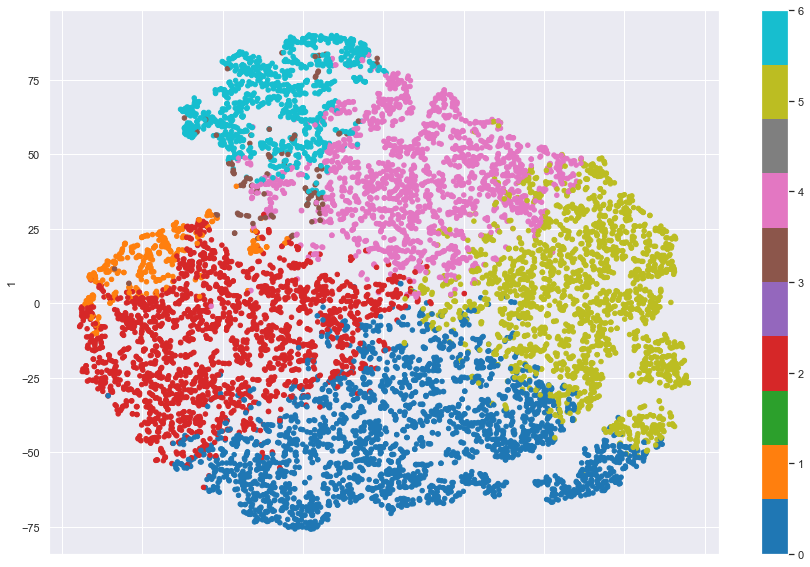

In [917]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

## Assess feature importance and reclassify outliers
### Using the R²
What proportion of each variables total SS is explained between clusters?

In [918]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [919]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

FirstPolYear     0.000332
BirthYear        0.812769
MonthSal         0.759688
CustMonVal       0.010500
ClaimsRate       0.007967
PremMotor        0.745877
PremHousehold    0.406097
PremHealth       0.279268
PremLife         0.602325
PremWork         0.498020
dtype: float64

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [920]:
# Preparing the data
X = df.drop(columns=['product_labels','behavior_labels','merged_labels'])
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 83.97% of the customers correctly


In [921]:
df

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0,product_labels,behavior_labels,merged_labels
CustID,,,,,,,,,,,,,,,,,,,,
1,-0.011850,0.710298,-0.284926,0.104337,-0.120911,0.355026,-0.371421,-0.085307,0.113906,-0.472286,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2,5
2,-0.019684,1.370149,-1.582361,-0.158818,0.129325,-1.054684,0.583578,-0.185601,3.228304,1.264620,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,6
3,-0.000098,0.101204,-0.198430,0.167904,-0.158618,-0.446702,0.039930,-0.158930,0.944722,1.126236,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2,3
4,-0.002057,0.659540,-1.217349,-0.100165,0.084762,-0.558529,-0.473799,0.471803,-0.132551,-0.249431,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2,0,4
5,-0.009891,0.253477,-0.643018,-0.073330,0.053911,0.179137,-0.461179,0.037162,-0.482280,0.005733,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,-0.013809,-0.964710,0.589546,-0.091490,0.074479,0.439545,-0.456499,0.007483,-0.672350,-0.513353,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,0
10293,-0.027519,-0.812437,-0.065227,0.630869,-0.254599,-0.789551,2.340579,-0.095819,-0.606670,1.245156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,3,2
10294,0.005777,0.405751,0.356007,0.177888,-0.182614,0.486269,-0.220125,-0.099200,-0.611316,-0.705845,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,2,5


In [922]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns)

FirstPolYear      0.000000
BirthYear         0.316692
MonthSal          0.064821
CustMonVal        0.000000
ClaimsRate        0.000000
PremMotor         0.584078
PremHousehold     0.000000
PremHealth        0.000000
PremLife          0.034409
PremWork          0.000000
EducDeg_2.0       0.000000
EducDeg_3.0       0.000000
EducDeg_4.0       0.000000
GeoLivArea_2.0    0.000000
GeoLivArea_3.0    0.000000
GeoLivArea_4.0    0.000000
Children_1.0      0.000000
dtype: float64

In [923]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out)
df_out.head()

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0,merged_labels
CustID,,,,,,,,,,,,,,,,,,
52,-0.017726,-0.101827,0.629334,-7.652638,8.438539,1.212927,-0.540018,-0.480127,-0.773298,-0.976190,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
113,0.011653,0.558024,-0.131828,-4.571934,5.110054,1.028109,-0.584116,-0.391090,-0.796740,-0.589065,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5
136,0.011653,1.014844,-0.285791,-5.332403,4.818683,-0.014610,-0.135047,-0.095448,2.003199,-0.859411,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4
150,-0.004016,1.319391,-1.316819,0.039969,-0.038642,-1.114022,-0.037349,-0.480127,-0.486926,7.987245,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6
172,-0.002057,1.065602,-1.228594,-85.230526,87.568036,0.365514,-0.372981,-0.016179,-0.733383,-0.441923,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5


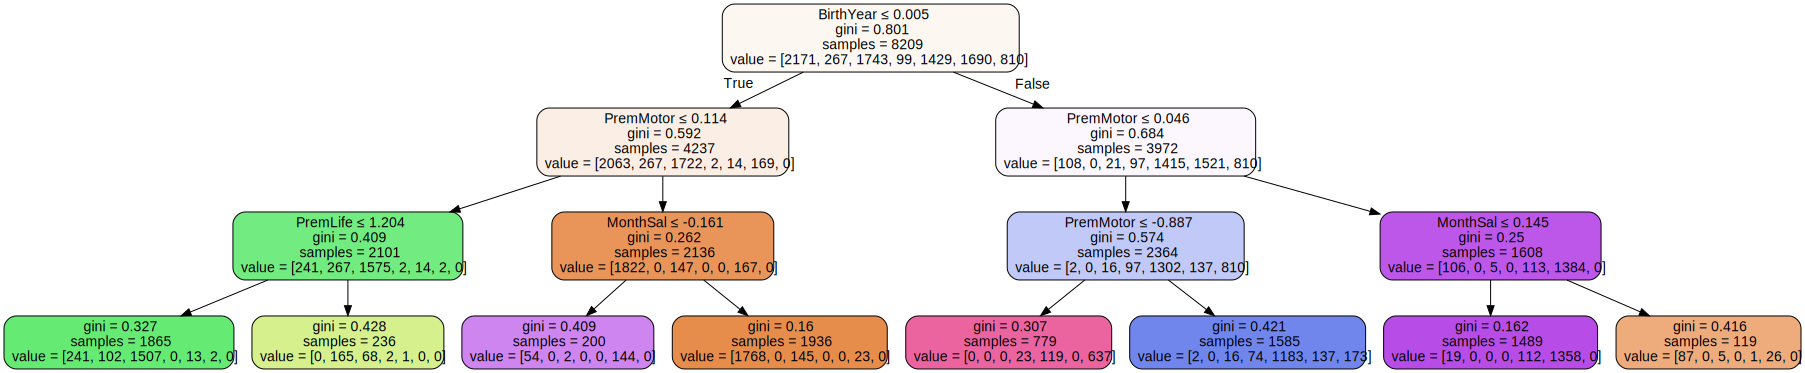

In [924]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)

In [925]:
df.columns

Index(['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork',
       'EducDeg_2.0', 'EducDeg_3.0', 'EducDeg_4.0', 'GeoLivArea_2.0',
       'GeoLivArea_3.0', 'GeoLivArea_4.0', 'Children_1.0', 'product_labels',
       'behavior_labels', 'merged_labels'],
      dtype='object')

In [926]:
non_metric_features

['EducDeg', 'GeoLivArea', 'Children']

In [927]:
## Who is buying PremLife Insurance?
##Potential PermLife buyers
ts = df[(df['PremLife'] <= 1.184) & (df['PremMotor'] <= 0.114) & (df['BirthYear'] <= -0.016)]

In [928]:
demo = data[['CustID']+non_metric_features].set_index('CustID')
x = pd.merge(demo, ts, left_index=True, right_index=True)

In [929]:
x['merged_labels'].value_counts()

2    1878
0     301
1     113
4      13
5       2
Name: merged_labels, dtype: int64

In [932]:
##Potential PermLife buyers
pt = x[x['merged_labels'] == 2]

In [933]:
for var in non_metric_features:    
    print(pt[var].value_counts())

2.0    847
3.0    785
1.0    188
4.0     54
Name: EducDeg, dtype: int64
4.0    790
1.0    532
3.0    352
2.0    204
Name: GeoLivArea, dtype: int64
0.0    1241
1.0     633
Name: Children, dtype: int64


In [934]:
pd.crosstab(pt['Children'], pt['GeoLivArea'])

GeoLivArea,1.0,2.0,3.0,4.0
Children,,,,
0.0,360,130,227,524
1.0,172,70,125,266
